In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import random
from PIL import Image
import matplotlib.pyplot as plt
from utils_week9to11 import LeNet5, train, test

In [2]:
batch_size = 128
epochs = 10
lr = 0.01
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

## label-A

标签翻转攻击A：把训练集前面50%样本的标签𝑦变成随机标签。

预期现象：模型的clean acc会略微下降，大概到96%左右。

建议使用的API：
- random.random()：返回一个[0,1)之间的随机数浮点数
- random.ranint(a, b)：返回一个int值，范围在[a, b]之间（两侧都是闭区间）

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


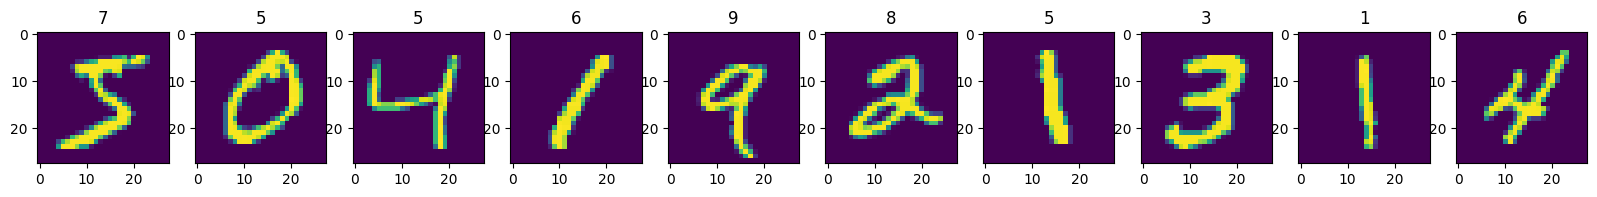

In [3]:
simple_transform = torchvision.transforms.ToTensor()
clean_train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=simple_transform, download=True)
xs = []
ys = []
# 攻击者可以对clean_train_data遍历和投毒，这里x是tensor图片，y是int标签
for idx, (x, y) in enumerate(clean_train_data):
    # TODO：对前面50%的样本做标签翻转攻击A，把它们的标签变成随机标签
    if idx < len(clean_train_data) // 2:
        y = random.randint(0, 9)
    xs.append(x)
    ys.append(y)

xs_tensor = torch.stack(xs)
ys_tensor = torch.tensor(ys)
print(xs_tensor.shape, ys_tensor.shape)

fig = plt.figure(figsize=(20, 3))
for i in range(10):
    a = fig.add_subplot(1, 10, i+1)
    x = xs_tensor[i]
    y = ys_tensor[i]
    a.set_title(str(y.item()))
    plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值

In [4]:
poison_data = torch.utils.data.TensorDataset(xs_tensor, ys_tensor)
poison_loader = torch.utils.data.DataLoader(dataset=poison_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

model = LeNet5()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 在投毒数据集上训练模型，在干净数据集上测试准确率
for epoch in range(epochs):
    train_loss = train(model, poison_loader, criterion, optimizer)
    test_acc = test(model, test_loader)
    print('Epoch %d: train_loss %.4f, test_acc %.2f%%' % (epoch, train_loss, test_acc))

Epoch 0: train_loss 1.8060, test_acc 95.83%
Epoch 1: train_loss 1.7356, test_acc 96.23%
Epoch 2: train_loss 1.7277, test_acc 96.95%
Epoch 3: train_loss 1.7244, test_acc 96.35%
Epoch 4: train_loss 1.7224, test_acc 94.80%
Epoch 5: train_loss 1.7184, test_acc 96.43%
Epoch 6: train_loss 1.7172, test_acc 96.53%
Epoch 7: train_loss 1.7129, test_acc 96.84%
Epoch 8: train_loss 1.7133, test_acc 94.73%
Epoch 9: train_loss 1.7124, test_acc 95.70%


## label-B

标签翻转攻击B：把前面60%的数字7样本的标签改为3

预期现象：模型的clean acc有一些下降，大概到90%左右，在label=3上准确率更高（大概在98%以上），在label=7上准确率低很多（可能在40%以下）。

本周的投毒策略较为简单，攻击性有限，因此得到的数据观测可能随机性较强。助教会结合具体代码考核，不一定严格按照上述数据指标。

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


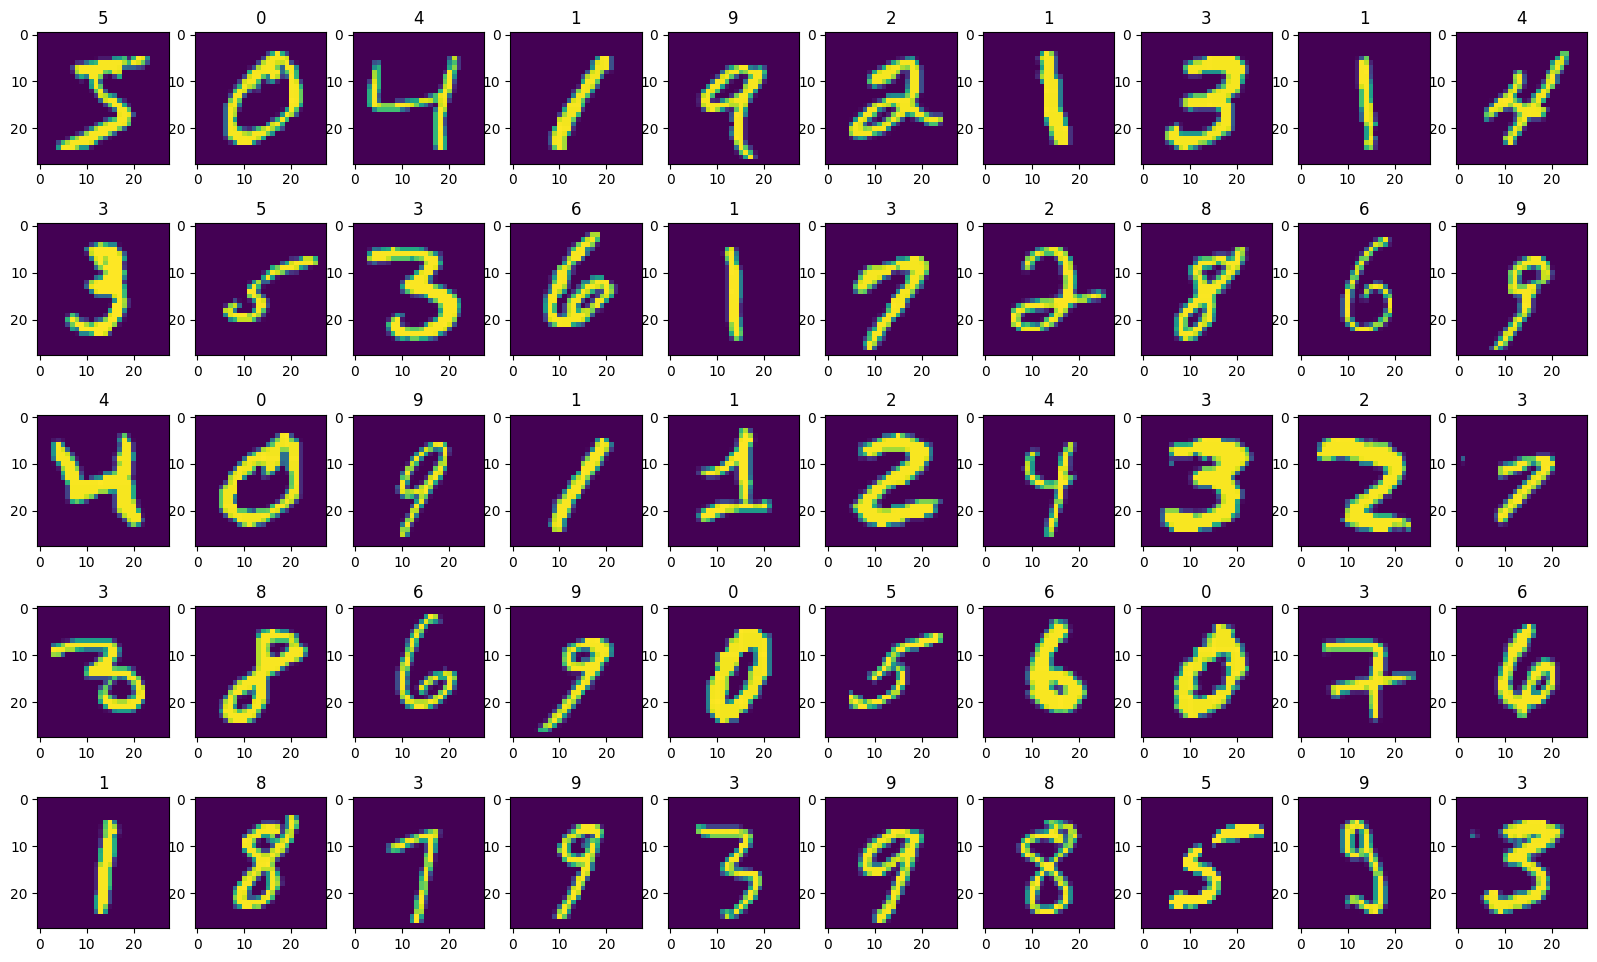

In [6]:
simple_transform = torchvision.transforms.ToTensor()
clean_train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=simple_transform, download=True)
xs = []
ys = []
# 攻击者可以对clean_train_data遍历和投毒
for idx, (x, y) in enumerate(clean_train_data):
    # TODO：对前面60%的数字7样本做标签翻转攻击B（实际上只修改了大约6%的训练集），把它们的标签改为3
    if y == 7 and idx < len(clean_train_data) * 0.6:
        y = 3
    xs.append(x)
    ys.append(y)

xs_tensor = torch.stack(xs)
ys_tensor = torch.tensor(ys)
print(xs_tensor.shape, ys_tensor.shape)

fig = plt.figure(figsize=(20, 12))
for i in range(50):
    a = fig.add_subplot(5, 10, i+1)
    x = xs_tensor[i]
    y = ys_tensor[i]
    a.set_title(str(y.item()))
    plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值

In [7]:
poison_data = torch.utils.data.TensorDataset(xs_tensor, ys_tensor)
poison_loader = torch.utils.data.DataLoader(dataset=poison_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

model = LeNet5()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 在投毒数据集上训练模型，在干净数据集上测试准确率
for epoch in range(epochs):
    train_loss = train(model, poison_loader, criterion, optimizer)
    test_acc = test(model, test_loader)
    print('Epoch %d: train_loss %.4f, test_acc %.2f%%' % (epoch, train_loss, test_acc))

Epoch 0: train_loss 0.2634, test_acc 88.07%
Epoch 1: train_loss 0.1403, test_acc 89.34%
Epoch 2: train_loss 0.1249, test_acc 87.91%
Epoch 3: train_loss 0.1276, test_acc 88.37%
Epoch 4: train_loss 0.1192, test_acc 93.82%
Epoch 5: train_loss 0.1194, test_acc 88.26%
Epoch 6: train_loss 0.1179, test_acc 88.10%
Epoch 7: train_loss 0.1152, test_acc 88.31%
Epoch 8: train_loss 0.1155, test_acc 88.23%
Epoch 9: train_loss 0.1154, test_acc 88.29%


In [11]:
'''
只在标签为target的样本上测试模型的准确率
'''
def test_on_target_label(model, loader, target, device=None):
    device = next(model.parameters()).device if device is None else device
    model.eval()
    total_num = 0.
    correct_num = 0.
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # TODO：对当前batch的inputs和labels进行过滤，只统计模型在labels==target的样本上的准确率
            target_indices = (labels == target).nonzero().squeeze(1)
            if target_indices.size(0) == 0:
                continue
            inputs = inputs[target_indices]
            labels = labels[target_indices]
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # TODO：记录当前batch中满足labels==target的样本总数batch_total_num，以及这样样本中模型预测正确的数目batch_correct_num
            batch_total_num = target_indices.size(0)
            batch_correct_num = torch.sum(preds == target).item()
            total_num += batch_total_num
            correct_num += batch_correct_num
    acc = correct_num / total_num * 100.
    return acc, correct_num, total_num

In [12]:
test_on_target_label(model, test_loader, target=3)

(98.8118811881188, 998.0, 1010.0)

In [15]:
test_on_target_label(model, test_loader, target=7)

(0.0, 0.0, 1028.0)

## label-C

标签翻转攻击C：把前面50%的样本的标签都改为3。

预期现象：模型的clean acc有大幅下降，大概到50%左右（随机性很强，但肯定低于80%），但是在label=3上准确率很高（大概在98%以上）。

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


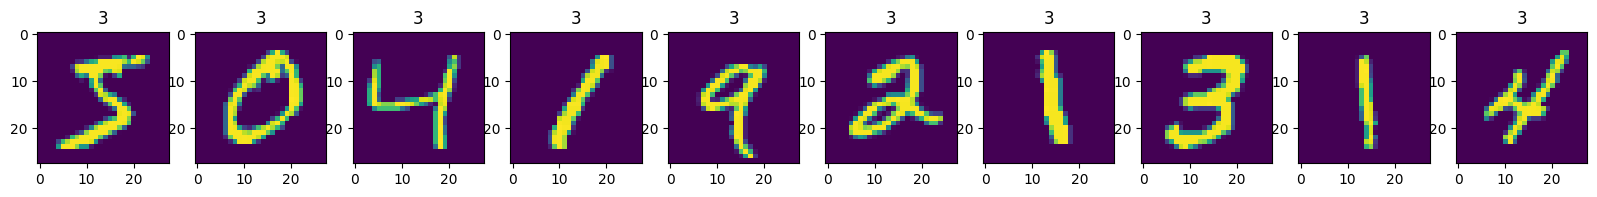

In [16]:
simple_transform = torchvision.transforms.ToTensor()
clean_train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=simple_transform, download=True)
xs = []
ys = []
# 攻击者可以对clean_train_data遍历和投毒
for idx, (x, y) in enumerate(clean_train_data):
    # TODO：对前面50%的样本做标签翻转攻击C，把它们的标签改为3
    if idx < len(clean_train_data) * 0.5:
        y = 3
    xs.append(x)
    ys.append(y)

xs_tensor = torch.stack(xs)
ys_tensor = torch.tensor(ys)
print(xs_tensor.shape, ys_tensor.shape)

fig = plt.figure(figsize=(20, 3))
for i in range(10):
    a = fig.add_subplot(1, 10, i+1)
    x = xs_tensor[i]
    y = ys_tensor[i]
    a.set_title(str(y.item()))
    plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值

In [17]:
poison_data = torch.utils.data.TensorDataset(xs_tensor, ys_tensor)
poison_loader = torch.utils.data.DataLoader(dataset=poison_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

model = LeNet5()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 在投毒数据集上训练模型，在干净数据集上测试准确率
for epoch in range(epochs):
    train_loss = train(model, poison_loader, criterion, optimizer)
    test_acc = test(model, test_loader)
    print('Epoch %d: train_loss %.4f, test_acc %.2f%%' % (epoch, train_loss, test_acc))

Epoch 0: train_loss 1.0090, test_acc 52.61%
Epoch 1: train_loss 0.6984, test_acc 30.78%
Epoch 2: train_loss 0.6763, test_acc 43.41%
Epoch 3: train_loss 0.6718, test_acc 22.12%
Epoch 4: train_loss 0.6649, test_acc 33.73%
Epoch 5: train_loss 0.6624, test_acc 70.82%
Epoch 6: train_loss 0.6643, test_acc 46.84%
Epoch 7: train_loss 0.6613, test_acc 44.52%
Epoch 8: train_loss 0.6609, test_acc 49.02%
Epoch 9: train_loss 0.6587, test_acc 52.63%


In [18]:
test_on_target_label(model, test_loader, target=3)

(99.60396039603961, 1006.0, 1010.0)

In [19]:
test_on_target_label(model, test_loader, target=7)

(50.97276264591439, 524.0, 1028.0)

## Input

输入篡改攻击：对全部的样本做输入扰动，加上范围为[-eps, eps]的噪声。

注意，正常样本的输入范围都在[0,1]之间，因此添加完扰动的样本也应该在同样的范围内。

预期现象：噪声对模型的clean acc有略微影响，趋势是随着eps增大，影响增大，三个扰动程度下test acc分别大概在98.5%、98.0%、96.5%左右。

可能用到的API：
- torch.rand(a, b, c)：返回一个形状为(a, b, c)维度的随机张量，每个位置的值都是在 [0, 1) 范围内的均匀噪声 
- torch.clamp(input, min=a, max=b)：将张量input做裁剪，使得小于a的部分裁为a、大于b的部分裁为b，并返回裁剪完的张量

In [20]:
def poisoning_input(clean_train_data, eps):
    xs = []
    ys = []
    # 攻击者可以对clean_train_data遍历和投毒
    for idx, (x, y) in enumerate(clean_train_data):
        # TODO：对全部的样本做输入篡改攻击，在它们的图片上添加范围为[-eps, eps]的均匀噪声
        # delta的计算方法是在[-eps, eps]上均匀采样，然后和x相加
        # 注意：delta的形状和x一样，且需要保证x和delta的值域在[0, 1]之间
        # torch.rand_like(x) 会生成一个与 x 形状相同的张量，其中的元素是从均匀分布 [0, 1] 中随机采样的。然后，这个随机张量乘以 2 * eps，使得元素的范围变为 [0, 2 * eps]。最后，从结果中减去 eps，使得元素的范围变为 [-eps, eps]。
        delta = torch.rand_like(x) * 2 * eps - eps
        x = torch.clamp(x + delta, 0, 1)
        xs.append(x)
        ys.append(y)

    xs_tensor = torch.stack(xs)
    ys_tensor = torch.tensor(ys)
    return xs_tensor, ys_tensor

preparing input-poisoning dataset with eps 0.3
preparing input-poisoning dataset with eps 0.6
preparing input-poisoning dataset with eps 0.9


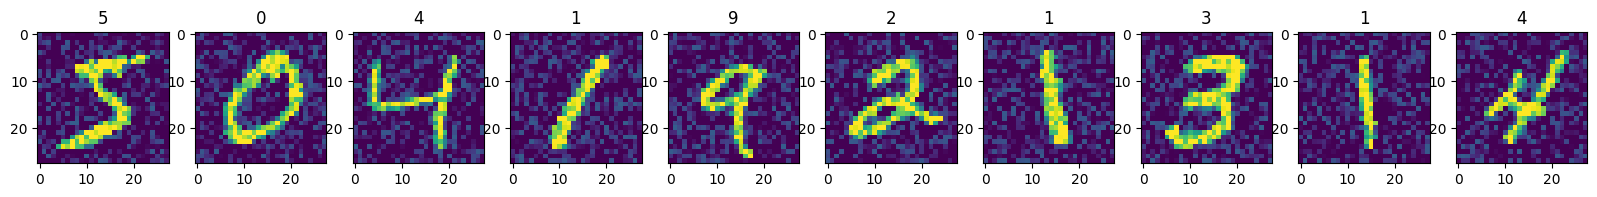

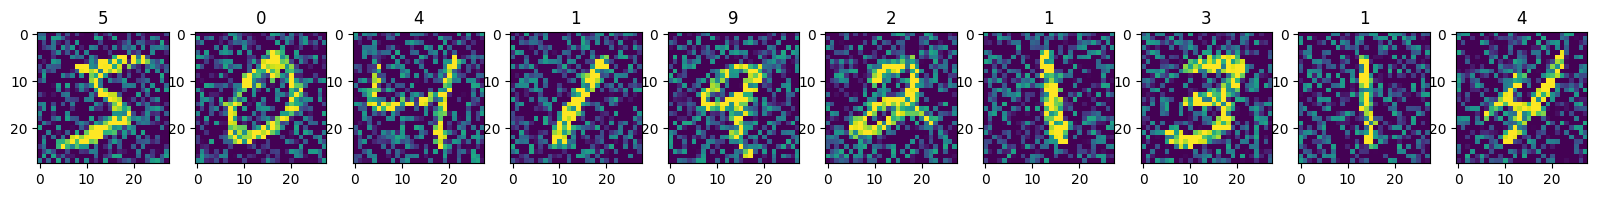

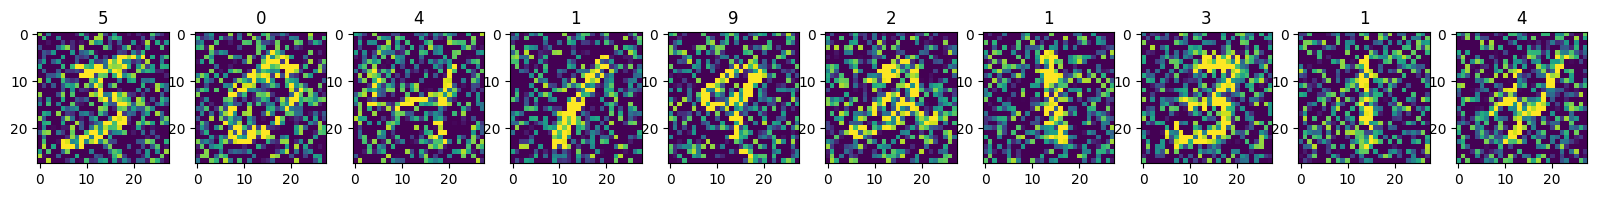

In [21]:
simple_transform = torchvision.transforms.ToTensor()
clean_train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=simple_transform, download=True)

eps_list = [0.3, 0.6, 0.9]
tensor_list = []

# 对于输入篡改攻击，首先我们可以尝试运行如下代码，可视化不同扰动大小下的前10张图片
for this_eps in eps_list:
    print('preparing input-poisoning dataset with eps', this_eps)
    xs_tensor, ys_tensor = poisoning_input(clean_train_data, this_eps)
    tensor_list.append((xs_tensor, ys_tensor))
    fig = plt.figure(figsize=(20, 3))
    for i in range(10):
        a = fig.add_subplot(1, 10, i+1)
        x = xs_tensor[i]
        y = ys_tensor[i]
        a.set_title(str(y.item()))
        plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值

In [22]:
test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

assert len(tensor_list) == len(eps_list)
for idx, (xs_tensor, ys_tensor) in enumerate(tensor_list):
    print('##### Experiment on eps=%.1f #####' % eps_list[idx])
    poison_data = torch.utils.data.TensorDataset(xs_tensor, ys_tensor)
    poison_loader = torch.utils.data.DataLoader(dataset=poison_data, batch_size=batch_size, shuffle=True)
    test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=simple_transform, download=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

    model = LeNet5()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 在投毒数据集上训练模型，在干净数据集上测试准确率
    for epoch in range(epochs):
        train_loss = train(model, poison_loader, criterion, optimizer)
        if epoch % 5 == 4:
            test_acc = test(model, test_loader)
            print('Epoch %d: train_loss %.4f, test_acc %.2f%%' % (epoch, train_loss, test_acc))
    print('Eps=%.1f, final model test_acc %.2f%%' % (eps_list[idx], test(model, test_loader)))

##### Experiment on eps=0.3 #####
Epoch 4: train_loss 0.0544, test_acc 98.67%
Epoch 9: train_loss 0.0522, test_acc 98.52%
Eps=0.3, final model test_acc 98.52%
##### Experiment on eps=0.6 #####
Epoch 4: train_loss 0.0929, test_acc 98.25%
Epoch 9: train_loss 0.0856, test_acc 97.85%
Eps=0.6, final model test_acc 97.85%
##### Experiment on eps=0.9 #####
Epoch 4: train_loss 0.2115, test_acc 96.86%
Epoch 9: train_loss 0.1614, test_acc 96.79%
Eps=0.9, final model test_acc 96.79%
